In [1]:
# @title 1. Dataset y Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import os

# Conexión a Google Drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/0.- Descargas/Comp_LitoCompletas.csv'

try:

    df = pd.read_csv(file_path)
    # Si detectamos que solo hay 1 columna, es probable que sea separado por tabulaciones
    if df.shape[1] < 2:
        df = pd.read_csv(file_path, sep='\t')

    print("Dataset cargado exitosamente.")
    print(f"Dimensiones: {df.shape}")
    display(df.head())
except FileNotFoundError:
    print(f"Error: No se encuentra el archivo en la ruta: {file_path}")
    print("Verifica que la carpeta '0.- Descargas' exista y el nombre sea exacto.")

Mounted at /content/drive
Dataset cargado exitosamente.
Dimensiones: (2695, 15)


,Id,Sondeo,Distancia,Potencia,Litologia,Densidad,Desde,Hasta,Este,Norte,Elevacion,Au(ppb),Cu(ppm),Ag(ppm),As(ppm)
0,1,PT101,50,3,SD,0,28.0,30.0,989.35,1050.59,214.92,25.0,50.0,0.0,110.0
1,1,PT101,50,3,MB,0,42.0,44.0,985.50,1050.10,201.47,16.0,29.0,0.0,91.0
2,1,PT101,50,3,MB,0,44.0,46.0,984.99,1050.04,199.53,18.0,215.0,0.0,46100.0
3,1,PT101,50,3,SD,0,46.0,48.0,984.47,1049.98,197.60,1267.0,16200.0,12.0,6830.0
4,1,PT101,50,3,MB,0,48.0,50.0,983.96,1049.91,195.67,91.0,2540.0,2.0,1980.0


In [3]:
# @title 2. Preprocesamiento de datos
from sklearn.preprocessing import StandardScaler


df_clean = df.dropna().copy()

# --- FILTRO DE LITOLOGÍAS
target_classes = ['GR', 'S', 'MB']
df_filtered = df_clean[df_clean['Litologia'].isin(target_classes)].copy()

print(f"Dimensiones después del filtro: {df_filtered.shape}")
print("Distribución de clases:")
print(df_filtered['Litologia'].value_counts())

# 2. Selección de Features (Entradas: Coordenadas y Leyes)
features_cols = ['Este', 'Norte', 'Elevacion', 'Au(ppb)', 'Cu(ppm)', 'Ag(ppm)', 'As(ppm)']
X = df_filtered[features_cols].values

# 3. Codificación del Target (SALIDA) usando ONE-HOT

y_dummies = pd.get_dummies(df_filtered['Litologia'], prefix='Lito')
y = y_dummies.values
class_names = y_dummies.columns

print("\nEjemplo de codificación One-Hot (3 primeras filas):")
print(y[:3])
print(f"Clases finales ({len(class_names)}): {list(class_names)}")

# 4. Escalado de Datos (Normalización de las entradas)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Dimensiones después del filtro: (2359, 15)
Distribución de clases:
Litologia
MB    881
GR    772
S     706
Name: count, dtype: int64

Ejemplo de codificación One-Hot (3 primeras filas):
[[False  True False]
 [False  True False]
 [False  True False]]
Clases finales (3): ['Lito_GR', 'Lito_MB', 'Lito_S']


In [4]:
# @title 3. División de datos (Train/Test)
from sklearn.model_selection import train_test_split

# Dividimos 80% entrenamiento, 20% prueba
# stratify=y asegura que mantenga la proporción de GR, S y MB en ambos grupos
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Datos de Entrenamiento: {X_train.shape}")
print(f"Datos de Prueba: {X_test.shape}")

Datos de Entrenamiento: (1887, 7)
Datos de Prueba: (472, 7)


In [5]:
# @title 4. Configuración del algoritmo (Creación del modelo)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

num_classes = y.shape[1] # Número de columnas generadas por el One-Hot

# Definición de la arquitectura
model = Sequential()

# Capas Ocultas (Procesamiento)
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())

# Capa de Salida
# Softmax dará la probabilidad para cada una de las columnas (litologías)
model.add(Dense(num_classes, activation='softmax'))

# Compilación
# 'categorical_crossentropy' porque 'y' es una matriz, no un vector de enteros
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,075 (12.01 KB)

 Trainable params: 2,883 (11.26 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4083 - loss: 1.3614 - val_accuracy: 0.5820 - val_loss: 0.9371
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6433 - loss: 0.8199 - val_accuracy: 0.5873 - val_loss: 0.8824
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6961 - loss: 0.7208 - val_accuracy: 0.5952 - val_loss: 0.8326
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7166 - loss: 0.6950 - val_accuracy: 0.6323 - val_loss: 0.7864
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7155 - loss: 0.6696 - val_accuracy: 0.6799 - val_loss: 0.7292
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7210 - loss: 0.6845 - val_accuracy: 0.7222 - val_loss: 0.6906
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7087 - loss: 0.6605 - val_accuracy: 0.7487 - val_loss: 0.6534
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7392 - loss: 0.6220 - val_accuracy: 0.7619 - 

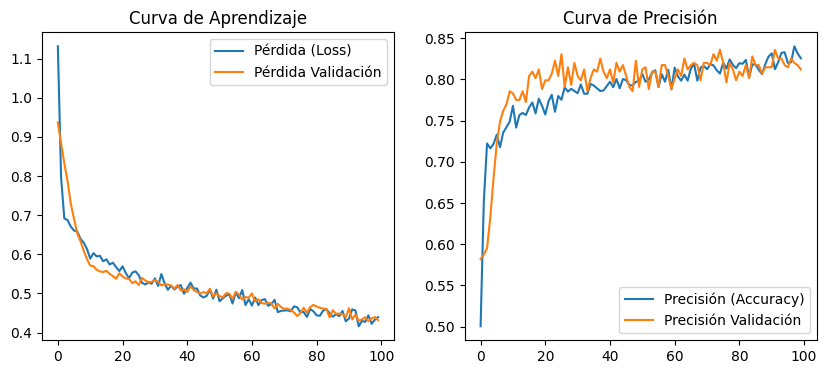

In [7]:
# @title 5. Entrenamiento (Ajuste del modelo)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Gráficas de rendimiento
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida (Loss)')
plt.plot(history.history['val_loss'], label='Pérdida Validación')
plt.title('Curva de Aprendizaje')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Precisión (Accuracy)')
plt.plot(history.history['val_accuracy'], label='Precisión Validación')
plt.title('Curva de Precisión')
plt.legend()
plt.show()

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

Reporte de Clasificación:
              precision    recall  f1-score   support

     Lito_GR       0.85      0.75      0.80       155
     Lito_MB       0.85      0.91      0.88       176
      Lito_S       0.78      0.82      0.80       141

    accuracy                           0.83       472
   macro avg       0.83      0.82      0.82       472
weighted avg       0.83      0.83      0.83       472



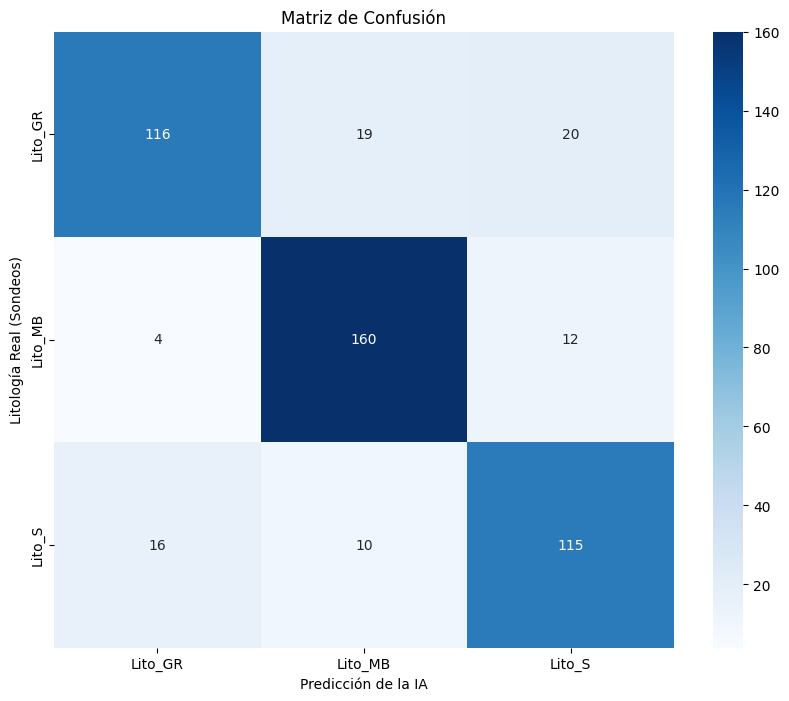

In [8]:
# @title 6. Evaluación (Métricas)
from sklearn.metrics import classification_report, confusion_matrix

# Predicción
y_pred_prob = model.predict(X_test)

# Convertimos vuelta de One-Hot a Índices (ej. [0, 1, 0] -> 1) para evaluar
y_test_indices = np.argmax(y_test, axis=1)
y_pred_indices = np.argmax(y_pred_prob, axis=1)

# Reporte
print("\nReporte de Clasificación:")
print(classification_report(y_test_indices, y_pred_indices, target_names=class_names))

# Matriz de Confusión
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_indices, y_pred_indices)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicción de la IA')
plt.ylabel('Litología Real (Sondeos)')
plt.title('Matriz de Confusión')
plt.show()

In [9]:
# @title 7. Validación Visual en los Sondajes
import plotly.express as px

# Predecir sobre los datos escalados
all_preds_prob = model.predict(X_scaled)
all_preds_indices = np.argmax(all_preds_prob, axis=1)

# Recuperar los nombres de las litologías
predicted_lithology_names = [class_names[i] for i in all_preds_indices]

df_viz = df_filtered.copy()
df_viz['Litologia_Predicha'] = predicted_lithology_names

# Visualización 3D
fig = px.scatter_3d(df_viz, x='Este', y='Norte', z='Elevacion',
                    color='Litologia_Predicha',
                    title='Validación: Litologías Predichas sobre Sondajes',
                    opacity=0.7,
                    size_max=5)
fig.show()

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [10]:
# @title 8. Generación del Modelo de Bloques (Modelado Implícito)

print("--- 1. Re-entrenando modelo solo con XYZ (Modelado Espacial) ---")

# 1. Preparar xyz
X_geo = df_filtered[['Este', 'Norte', 'Elevacion']].values
scaler_geo = StandardScaler()
X_geo_scaled = scaler_geo.fit_transform(X_geo)

# 2. nueva red neuronal específica para coordenadas
model_geo = Sequential()
model_geo.add(Dense(128, input_dim=3, activation='relu')) # Más neuronas para capturar formas complejas 3D
model_geo.add(BatchNormalization())
model_geo.add(Dropout(0.1))
model_geo.add(Dense(64, activation='relu'))
model_geo.add(BatchNormalization())
model_geo.add(Dense(32, activation='relu'))
model_geo.add(Dense(num_classes, activation='softmax'))

model_geo.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Usamos más épocas porque aprender formas 3D solo con XYZ es difícil
model_geo.fit(X_geo_scaled, y, epochs=150, batch_size=32, verbose=0)
print("Modelo espacial entrenado.")

# --- 2. GENERACIÓN DEL MODELO DE BLOQUES
print("\n--- 2. Generando Malla de Bloques (Grid) ---")

# límites del yacimiento basados en los sondajes
x_min, x_max = df_filtered['Este'].min(), df_filtered['Este'].max()
y_min, y_max = df_filtered['Norte'].min(), df_filtered['Norte'].max()
z_min, z_max = df_filtered['Elevacion'].min(), df_filtered['Elevacion'].max()

# Tamaño del bloque (Resolución)
step = 20 # Bloques de 20x20x20 metros

grid_x, grid_y, grid_z = np.meshgrid(
    np.arange(x_min, x_max, step),
    np.arange(y_min, y_max, step),
    np.arange(z_min, z_max, step)
)

# Aplanamos la malla para que sea una lista de coordenadas X,Y,Z
block_model_coords = np.c_[grid_x.ravel(), grid_y.ravel(), grid_z.ravel()]
print(f"Bloques totales a predecir: {len(block_model_coords)}")

# --- 3. PREDICCIÓN

block_model_scaled = scaler_geo.transform(block_model_coords)

# La IA predice la litología para cada bloque vacío
block_preds_prob = model_geo.predict(block_model_scaled)
block_preds_indices = np.argmax(block_preds_prob, axis=1)
block_lithology = [class_names[i] for i in block_preds_indices]

# --- 4. VISUALIZACIÓN DEL MODELO DE BLOQUES ---
df_blocks = pd.DataFrame(block_model_coords, columns=['Este', 'Norte', 'Elevacion'])
df_blocks['Litologia'] = block_lithology

# Filtramos para visualizar

fig = px.scatter_3d(df_blocks, x='Este', y='Norte', z='Elevacion',
                    color='Litologia',
                    title='Modelo de Bloques Generado por IA (Solo XYZ)',
                    opacity=0.6,
                    symbol='Litologia', # Diferentes formas para distinguir mejor
                    size_max=5)
fig.show()

# Exportar para abrir en RecMin (CSV: X, Y, Z, Litologia)
df_blocks.to_csv('Modelo_Bloques_IA.csv', index=False)

--- 1. Re-entrenando modelo solo con XYZ (Modelado Espacial) ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Modelo espacial entrenado.

--- 2. Generando Malla de Bloques (Grid) ---
Bloques totales a predecir: 3927
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
